Lab5. Text corpus creation and binary classification using DNN (TAMIL)

In [2]:
import numpy as np

def load_data():
    # Load motivational quotes and demotivational quotes from files
    with open('motivational_quotes.txt', 'r', encoding='utf-8') as f:
        motivational_quotes = f.readlines()
    with open('demotivational_quotes.txt', 'r', encoding='utf-8') as f:
        demotivational_quotes = f.readlines()

    # Combine both classes of quotes and create labels (1 for motivational, 0 for demotivational)
    quotes = motivational_quotes + demotivational_quotes
    labels = np.concatenate([np.ones(len(motivational_quotes)), np.zeros(len(demotivational_quotes))])

    return quotes, labels

quotes, labels = load_data()

In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

def preprocess_data(quotes):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(quotes)
    sequences = tokenizer.texts_to_sequences(quotes)
    vocab_size = len(tokenizer.word_index) + 1

    # Pad the sequences to have the same length
    max_sequence_length = max(len(seq) for seq in sequences)
    padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post')

    return padded_sequences, vocab_size

X, vocab_size = preprocess_data(quotes)

In [4]:
load_data()

(['1.ஒவ்வொரு சிறிய மாற்றமும் பெரிய வெற்றியின் ஒரு பகுதியாகும்\n',
  '2.நம்பிக்கை வெற்றியோடு வரும். ஆனால் வெற்றி நம்பிக்கை உள்ளோரிடம் மட்டுமே வரும்.\n',
  '3.மனம் உங்களைக் கட்டுப்படுத்தும் முன் உங்கள் மனதைக் கட்டுப்படுத்துங்கள்\n',
  '4.அறிவை விட முக்கியமானது, உங்கள் இலக்கை அடைய உங்கள் விருப்பம்.\n',
  '5.செய்ய முடிந்தவன் சாதிக்கிறான், செய்ய முடியாதவன் போதிக்கிறான்.\n',
  '6.மலையைப் பார்த்து மலைத்து விடாதே, மலை மீது ஏறினால் அதுவும் உன் காலடியில்.\n',
  '7.இன்று நீங்கள் உணரும் வலி நாளை நீங்கள் உணரும் பலமாக இருக்கும்.\n',
  '8.ஒரு சிக்கல் உங்கள் சிறந்ததைச் செய்வதற்கான வாய்ப்பாகும்.\n',
  '9.ஒரு மனிதன் தன்னை உலகிற்கு புத்திசாலி என்று நிரூபிப்பதை நிறுத்தும்போது வெற்றி பெறுகிறான்.\n',
  '10.விழுவதெல்லாம் எழுவதற்குத்தானே தவிர அழுவதற்கு அல்ல.\n',
  '11.நீ இன்று செய்யும் சின்ன சின்ன முயற்சிகள் நாளை மாறும் வெற்றியின் ஆணி வேர்கள்.\n',
  '12.கிடைக்கும் வாய்ப்புகளைப் பயன்படுத்தி வெற்றிக் கனியை எட்டுபவனே சிறந்த சாமர்த்தியசாலி ஆகிறான்.\n',
  '13.சிந்தனை மட்டும் செய்ய உனக்கு தெரியுமானால் நீயே உனக்கான 

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

def create_model(nodes=32, layers=1):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=nodes, input_length=X.shape[1]))

    for _ in range(layers):
        model.add(LSTM(nodes, return_sequences=True))
    model.add(LSTM(nodes))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [6]:
from sklearn.model_selection import train_test_split
import time
import matplotlib.pyplot as plt

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

# Function to train and evaluate the model
def train_and_evaluate_model(nodes, layers):
    model = create_model(nodes=nodes, layers=layers)
    start_time = time.time()
    model.fit(X_train, y_train, epochs=5, batch_size=128, verbose=1)
    end_time = time.time()
    _, train_accuracy = model.evaluate(X_train, y_train)
    _, test_accuracy = model.evaluate(X_test, y_test)
    return train_accuracy, test_accuracy, end_time - start_time

# Define the configurations to evaluate
nodes_list = [6, 32, 64, 128, 256, 512, 1024]
layers_list = [1, 2, 3, 4, 5]

# Create a dictionary to store the results for each configuration
results = {}

# Find the best configuration
best_accuracy = 0
best_config = None

# Evaluate each configuration and store the components
for nodes in nodes_list:
    if nodes == 32:  # Evaluate all layers for node 32
        for layers in layers_list:
            train_accuracy, test_accuracy, running_time = train_and_evaluate_model(nodes, layers)
            results[(nodes, layers)] = {
                "Train Accuracy": train_accuracy,
                "Test Accuracy": test_accuracy,
                "Running Time": running_time
            }
            if test_accuracy > best_accuracy:
                best_accuracy = test_accuracy
                best_config = (nodes, layers)
    else:  # Only evaluate the first layer for other nodes
        layers = 1
        train_accuracy, test_accuracy, running_time = train_and_evaluate_model(nodes, layers)
        results[(nodes, layers)] = {
            "Train Accuracy": train_accuracy,
            "Test Accuracy": test_accuracy,
            "Running Time": running_time
        }
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            best_config = (nodes, layers)

# Print the results for all configurations
for config, values in results.items():
    node, layers = config
    print("Node: {}, Layers: {}".format(node, layers))
    print("Training Accuracy:", values["Train Accuracy"])
    print("Testing Accuracy:", values["Test Accuracy"])
    print("Running Time:", values["Running Time"])
    print("-" * 30)

Epoch 1/5
1/1 [==============================] - 5s 5s/step - loss: 0.6923 - accuracy: 0.5000
Epoch 2/5
1/1 [==============================] - 0s 25ms/step - loss: 0.6915 - accuracy: 0.5000
Epoch 3/5
1/1 [==============================] - 0s 25ms/step - loss: 0.6908 - accuracy: 0.5938
Epoch 4/5
1/1 [==============================] - 0s 20ms/step - loss: 0.6901 - accuracy: 0.5625
Epoch 5/5
1/1 [==============================] - 1s 887ms/step - loss: 0.6982 - accuracy: 0.3750
Epoch 1/5
1/1 [==============================] - 5s 5s/step - loss: 0.6932 - accuracy: 0.5312
Epoch 2/5
1/1 [==============================] - 0s 25ms/step - loss: 0.6918 - accuracy: 0.5312
Epoch 3/5
1/1 [==============================] - 0s 29ms/step - loss: 0.6902 - accuracy: 0.5312
Epoch 4/5
1/1 [==============================] - 0s 27ms/step - loss: 0.6885 - accuracy: 0.5312
Epoch 5/5
1/1 [==============================] - 1s 911ms/step - loss: 0.7022 - accuracy: 0.3750
Epoch 1/5
1/1 [===========================

1/1 [==============================] - 2s 2s/step - loss: 0.6878 - accuracy: 0.5312


1/1 [==============================] - 1s 1s/step - loss: 0.7035 - accuracy: 0.3750
Epoch 1/5
1/1 [==============================] - 18s 18s/step - loss: 0.6931 - accuracy: 0.6562
Epoch 2/5
1/1 [==============================] - 0s 37ms/step - loss: 0.6924 - accuracy: 0.5312
Epoch 3/5
1/1 [==============================] - 0s 37ms/step - loss: 0.6916 - accuracy: 0.5312
Epoch 4/5
1/1 [==============================] - 0s 38ms/step - loss: 0.6906 - accuracy: 0.5312
Epoch 5/5
1/1 [==============================] - 2s 2s/step - loss: 0.7038 - accuracy: 0.3750
Epoch 1/5
1/1 [==============================] - 13s 13s/step - loss: 0.6931 - accuracy: 0.5938
Epoch 2/5
1/1 [==============================] - 0s 44ms/step - loss: 0.6927 - accuracy: 0.5312
Epoch 3/5
1/1 [==============================] - 0s 54ms/step - loss: 0.6923 - accuracy: 0.5312
Epoch 4/5
1/1 [==============================] - 0s 44ms/step - loss: 0.6919 - accuracy: 0.5312
Epoch 5/5
1/1 [==============================] - 2s 2s

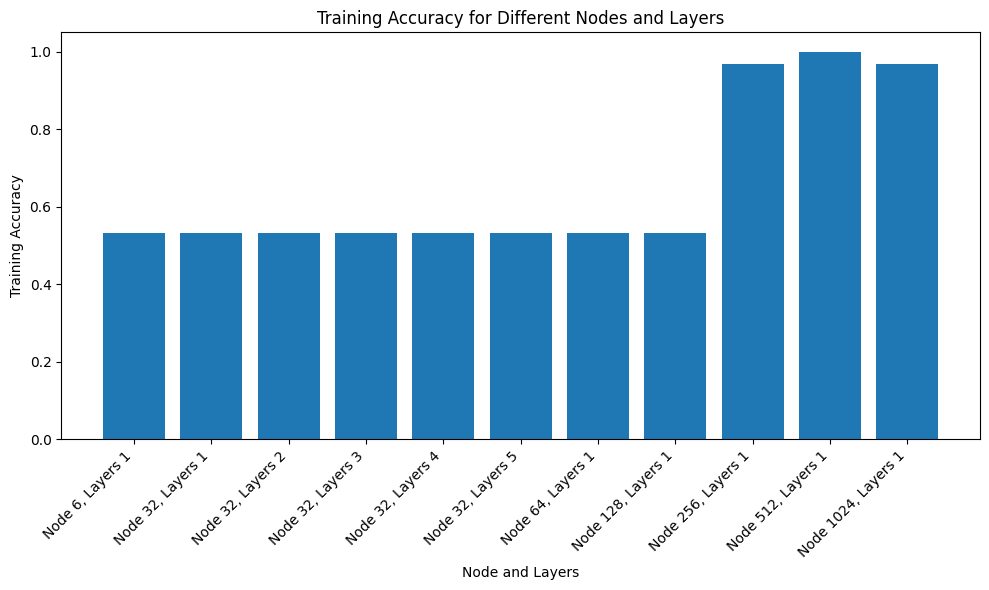

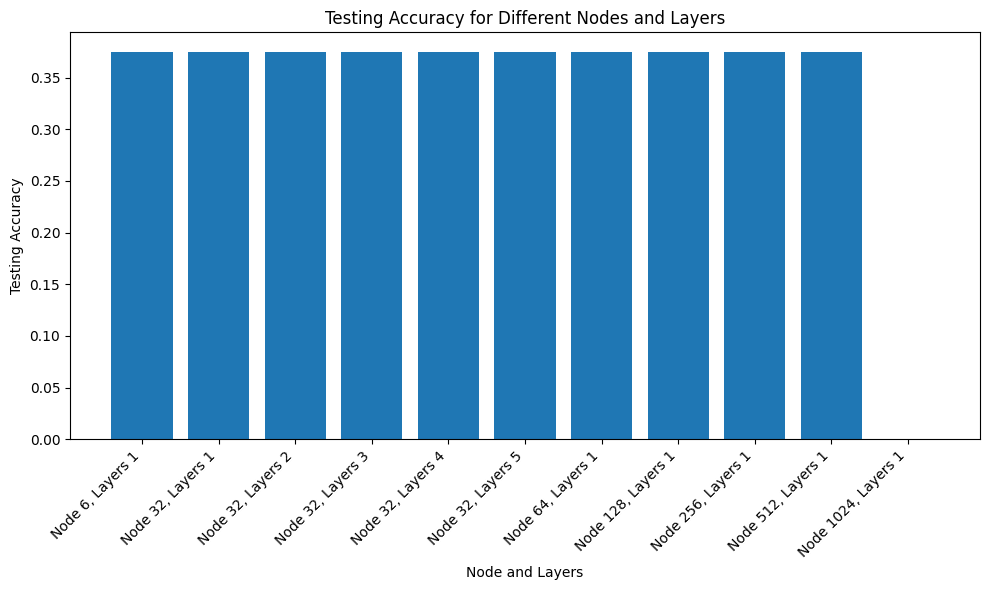

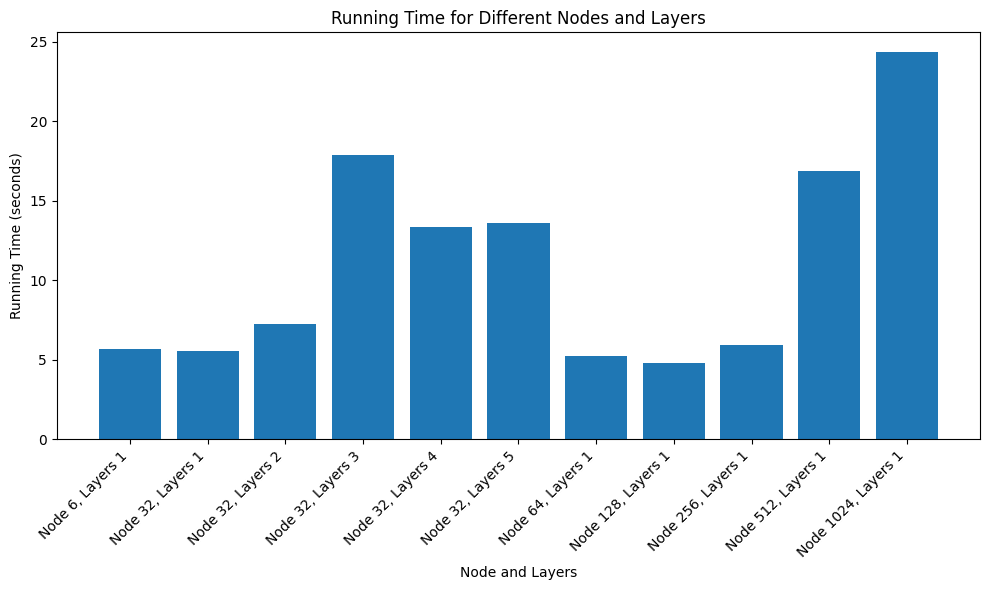

BEST CONFIGURATION: (6, 1)
Components of the Best Configuration:
Training Accuracy: 0.53125
Testing Accuracy: 0.375
Running Time: 5.671963691711426


In [7]:
# Plot the graphs for Training Accuracy, Testing Accuracy, and Running Time for all nodes with their layers
x_labels = ["Node {}, Layers {}".format(node, layers) for node, layers in results.keys()]
train_accuracies = [values["Train Accuracy"] for values in results.values()]
test_accuracies = [values["Test Accuracy"] for values in results.values()]
running_times = [values["Running Time"] for values in results.values()]

# Plot the bar graph for Training Accuracy
plt.figure(figsize=(10, 6))
plt.bar(x_labels, train_accuracies)
plt.xticks(rotation=45, ha='right')
plt.xlabel("Node and Layers")
plt.ylabel("Training Accuracy")
plt.title("Training Accuracy for Different Nodes and Layers")
plt.tight_layout()
plt.show()

# Plot the bar graph for Testing Accuracy
plt.figure(figsize=(10, 6))
plt.bar(x_labels, test_accuracies)
plt.xticks(rotation=45, ha='right')
plt.xlabel("Node and Layers")
plt.ylabel("Testing Accuracy")
plt.title("Testing Accuracy for Different Nodes and Layers")
plt.tight_layout()
plt.show()

# Plot the bar graph for Running Time
plt.figure(figsize=(10, 6))
plt.bar(x_labels, running_times)
plt.xticks(rotation=45, ha='right')
plt.xlabel("Node and Layers")
plt.ylabel("Running Time (seconds)")
plt.title("Running Time for Different Nodes and Layers")
plt.tight_layout()
plt.show()

# Print the results for the best configuration
print("BEST CONFIGURATION:", best_config)
print("Components of the Best Configuration:")
print("Training Accuracy:", results[best_config]["Train Accuracy"])
print("Testing Accuracy:", results[best_config]["Test Accuracy"])
print("Running Time:", results[best_config]["Running Time"])

In [8]:
# Function to read text from a file and return the words
def read_text_from_file(file_path):
    with open(file_path, "r", encoding="utf-8") as file:
        text = file.read()
    return text

# Function to clean and tokenize the text into words
def preprocess_text(text):
    # Remove unwanted characters and split the text into words
    words = text.strip().replace("\n", " ").split(" ")
    # Remove any empty strings from the list of words
    words = [word.strip() for word in words if word.strip()]
    return words

# Function to count the word frequency in a list of words
def count_word_frequency(words):
    word_frequency = {}
    for word in words:
        if word in word_frequency:
            word_frequency[word] += 1
        else:
            word_frequency[word] = 1
    return word_frequency

# Read and preprocess the motivational_quotes.txt
motivational_quotes_text = read_text_from_file("motivational_quotes.txt")
motivational_quotes_words = preprocess_text(motivational_quotes_text)
motivational_quotes_word_frequency = count_word_frequency(motivational_quotes_words)

# Read and preprocess the demotivational_quotes.txt
demotivational_quotes_text = read_text_from_file("demotivational_quotes.txt")
demotivational_quotes_words = preprocess_text(demotivational_quotes_text)
demotivational_quotes_word_frequency = count_word_frequency(demotivational_quotes_words)

# Display the word frequency for motivational_quotes
print("Word Frequency for motivational_quotes:")
for word, frequency in motivational_quotes_word_frequency.items():
    print(f"{word}: {frequency}")

# Display the word frequency for demotivational_quotes
print("\nWord Frequency for demotivational_quotes:")
for word, frequency in demotivational_quotes_word_frequency.items():
    print(f"{word}: {frequency}")

Word Frequency for motivational_quotes:
1.ஒவ்வொரு: 1
சிறிய: 1
மாற்றமும்: 1
பெரிய: 1
வெற்றியின்: 3
ஒரு: 2
பகுதியாகும்: 1
2.நம்பிக்கை: 1
வெற்றியோடு: 1
வரும்.: 2
ஆனால்: 1
வெற்றி: 2
நம்பிக்கை: 2
உள்ளோரிடம்: 1
மட்டுமே: 2
3.மனம்: 1
உங்களைக்: 1
கட்டுப்படுத்தும்: 1
முன்: 1
உங்கள்: 4
மனதைக்: 1
கட்டுப்படுத்துங்கள்: 1
4.அறிவை: 1
விட: 2
முக்கியமானது,: 1
இலக்கை: 1
அடைய: 1
விருப்பம்.: 1
5.செய்ய: 1
முடிந்தவன்: 1
சாதிக்கிறான்,: 1
செய்ய: 2
முடியாதவன்: 1
போதிக்கிறான்.: 1
6.மலையைப்: 1
பார்த்து: 1
மலைத்து: 1
விடாதே,: 1
மலை: 1
மீது: 1
ஏறினால்: 1
அதுவும்: 1
உன்: 1
காலடியில்.: 1
7.இன்று: 1
நீங்கள்: 3
உணரும்: 2
வலி: 1
நாளை: 2
பலமாக: 1
இருக்கும்.: 1
8.ஒரு: 1
சிக்கல்: 1
சிறந்ததைச்: 1
செய்வதற்கான: 1
வாய்ப்பாகும்.: 1
9.ஒரு: 1
மனிதன்: 1
தன்னை: 1
உலகிற்கு: 1
புத்திசாலி: 1
என்று: 1
நிரூபிப்பதை: 1
நிறுத்தும்போது: 1
பெறுகிறான்.: 1
10.விழுவதெல்லாம்: 1
எழுவதற்குத்தானே: 1
தவிர: 1
அழுவதற்கு: 1
அல்ல.: 1
11.நீ: 1
இன்று: 1
செய்யும்: 1
சின்ன: 2
முயற்சிகள்: 1
மாறும்: 1
ஆணி: 1
வேர்கள்.: 1
12.கிடைக்கும்: 1
வாய்ப்புகளைப்: 1
பயன்ப

In [9]:
from tabulate import tabulate

# Function to read text from a file and return the words
def read_text_from_file(file_path):
    with open(file_path, "r", encoding="utf-8") as file:
        text = file.read()
    return text

# Function to clean and tokenize the text into words
def preprocess_text(text):
    # Remove unwanted characters and split the text into words
    words = text.strip().replace("\n", " ").split(" ")
    # Remove any empty strings from the list of words
    words = [word.strip() for word in words if word.strip()]
    return words

# Function to count the word frequency in a list of words
def count_word_frequency(words):
    word_frequency = {}
    for word in words:
        if word in word_frequency:
            word_frequency[word] += 1
        else:
            word_frequency[word] = 1
    return word_frequency

# Function to create a neat table from word frequency dictionary
def create_table(word_frequency):
    table = []
    for word, frequency in word_frequency.items():
        table.append([word, frequency])
    return table

# Read and preprocess the motivational_quotes.txt
motivational_quotes_text = read_text_from_file("motivational_quotes.txt")
motivational_quotes_words = preprocess_text(motivational_quotes_text)
motivational_quotes_word_frequency = count_word_frequency(motivational_quotes_words)

# Read and preprocess the demotivational_quotes.txt
demotivational_quotes_text = read_text_from_file("demotivational_quotes.txt")
demotivational_quotes_words = preprocess_text(demotivational_quotes_text)
demotivational_quotes_word_frequency = count_word_frequency(demotivational_quotes_words)

# Display the word frequency for motivational_quotes in a table
print("Word Frequency for motivational_quotes:")
motivational_quotes_table = create_table(motivational_quotes_word_frequency)
print(tabulate(motivational_quotes_table, headers=["Word", "Frequency"], tablefmt="pretty"))

# Display the word frequency for demotivational_quotes in a table
print("\nWord Frequency for Sad Quotes:")
demotivational_quotes_table = create_table(demotivational_quotes_word_frequency)
print(tabulate(demotivational_quotes_table, headers=["Word", "Frequency"], tablefmt="pretty"))

Word Frequency for motivational_quotes:
+------------------+-----------+
|       Word       | Frequency |
+------------------+-----------+
|     1.ஒவ்வொரு     |     1     |
|      சிறிய       |     1     |
|     மாற்றமும்      |     1     |
|      பெரிய       |     1     |
|     வெற்றியின்     |     3     |
|       ஒரு        |     2     |
|    பகுதியாகும்    |     1     |
|    2.நம்பிக்கை     |     1     |
|    வெற்றியோடு     |     1     |
|      வரும்.       |     2     |
|       ஆனால்       |     1     |
|      வெற்றி       |     2     |
|     நம்பிக்கை      |     2     |
|     உள்ளோரிடம்     |     1     |
|      மட்டுமே      |     2     |
|      3.மனம்       |     1     |
|      உங்களைக்      |     1     |
|   கட்டுப்படுத்தும்   |     1     |
|       முன்        |     1     |
|       உங்கள்       |     4     |
|      மனதைக்       |     1     |
|  கட்டுப்படுத்துங்கள்  |     1     |
|     4.அறிவை      |     1     |
|       விட        |     2     |
|   முக்கியமானது,   |     1     |
| 